# Full CIFAR10 Dataset Implementation

In [1]:
%matplotlib inline

# file manipulation
import os.path

# arrays and visualization
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Special package provided by pytorch
import torchvision
import torchvision.transforms as transforms

In [2]:
## Hyperparameters.


# image channel 3=RGB, 1=Grayscale
img_channels = 3

# Class labels.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Data directory.
data_dir = '../datasets/cifar'  # Dataset directory.
download = True                 # Download dataset iff not already downloaded.
normalize = 0.5                 # Normalize dataset.

# Training parameters
batch_size = 16  # Mini-batch size.
lr = 1e-2        # Optimizer's learning rate.
epochs = 5       # Number of full passes over entire dataset.

In [3]:
# Should normalize images or not.
# Normalization helps convergence.
if normalize:
    # Transform rule: Convert to Tensor, Normalize images in range -1 to 1.
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))])
else:
    # Transform rule: Convert to Tensor without normalizing image
    transform = transforms.Compose([transforms.ToTensor()])

# Download the training set and apply the transform rule to each.
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=download, transform=transform)
# Load the training set into mini-batches and shuffle them
trainset = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download the testing set and apply the transform rule to each.
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=download, transform=transform)
# Load the testing set into mini-batches without shuffling.
testset = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


img_size = 32	img_batch=16	img_channel=3


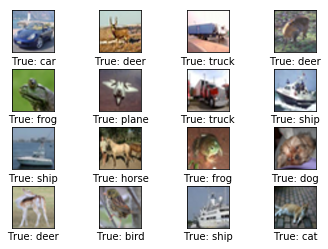

In [4]:
# Helper function to plot images and labels.
def imshow(images, labels, pred=None, **kwargs):
    
    # Keyword arguments.
    normalize = kwargs.get('normalize', 0.5)
    smooth = kwargs.get('smooth', True)
    
    # Image dimensions
    img_shape = images.size()
    img_size = img_shape[-1]
    img_channel = img_shape[-3]
    img_batch = img_shape[0] if len(img_shape) > 3 else 1

    print(f'img_size = {img_size}\timg_batch={img_batch}'
          f'\timg_channel={img_channel}')
    
    # Normalize image.
    images = images / 2 + normalize if normalize else images
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(4, 4)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    wspace, hspace = 0.2, 0.8 if pred is not None else 0.4
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    for i, ax in enumerate(axes.flat):
        # cmap type.
        cmap = 'Greys' if img_channel == 1 else None
        # Interpolation type.
        smooth = 'spline16' if smooth else 'nearest'

        # Reshape image based on channel.
        if img_channel == 1:
            img = images[i].view(img_size, img_size).numpy()
        else:
            img = np.transpose(images[i].numpy(), (1, 2, 0))

        # Plot image.
        ax.imshow(img, interpolation=smooth, cmap=cmap)
            
        # Name of the true class.
        labels_name = classes[labels[i]]

        # Show true and predicted classes.
        if pred is None:
            xlabel = f'True: {labels_name}'
        else:
            # Name of the predicted class.
            pred_name = classes[pred[i]]
            
            xlabel = f'True: {labels_name}\nPred: {pred_name}'

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


# Visualization function to visualize dataset.
def visualize(data, **kwargs):
    
    # Iterate over the data.
    data_iter = iter(data)
    
    # Unpack images and labels.
    images, labels = data_iter.next()
    
    # Free up memory
    del data_iter
    
    # Call to helper function for plotting images.
    imshow(images, labels=labels, **kwargs)



# Let's visualize some training set.
visualize(trainset, smooth=True)

In [5]:
class Network(nn.Module):
    
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        
        # Hyper-parameters
        self._img_channels = kwargs.get('img_channels')
        self._num_classes = kwargs.get('num_classes')
        
        # 2 convolutional & 3 fully connected layers
        self.conv1 = nn.Conv2d(self._img_channels, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        flatten_size = self.conv2.out_channels * 7 * 7
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self._num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Flatten layer
        x = x.view(-1, self._flatten(x))
        # Fully connected layers
        x = F.relu(self.fc1(x))     # relu + linear
        x = F.dropout(x, p=0.2)     # 20% dropout
        x = F.relu(self.fc2(x))     # relu + linear
        # Output layer
        x = self.fc3(x)             # linear
        return x
    
    def _flatten(self, x):
        size = x.size()[1:]  # input shape excluding batch dim.
        return torch.Tensor(size).numel()

In [6]:
# Instantiate the network and pass in our parameters.
net = Network(img_channels=img_channels, num_classes=len(classes))

In [7]:
# Loss function criterion
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
# Loop over the data multiple times.
for epoch in range(epochs):

    # Loop through the training dataset (batch by batch).
    for i, data in enumerate(trainset):
        
        # Get the inputs and labels.
        inputs, labels = data
        
        # Wrap them in Variable (explained in section 2).
        inputs, labels = Variable(inputs), Variable(labels)
        
        # Zero the optimizer gradient buffer
        # to prevent gradient accumulation.
        optimizer.zero_grad()
        
        # Forward and backward propagation.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        
        # Update learnable parameters w.r.t the loss.
        optimizer.step()
        
        # Print statistics.
        print(f'\rEpoch: {epoch+1:,}\tIter: {i+1:,}\tLoss: {loss.data[0]:.4f}', end='')

    # Line break.
    print()


print('\nFinished training!')

Epoch: 1	Iter: 1,175	Loss: 1.7306

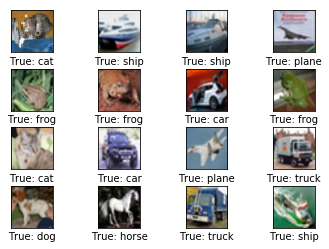

In [9]:
# Look at some test data.
visualize(testset)

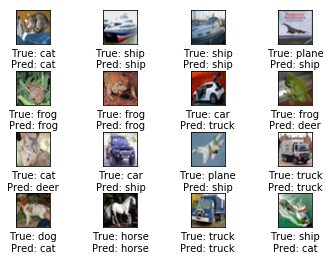

In [10]:
# Let's make some predictions on the testset.
test_iter = iter(testset)
images, labels = test_iter.next()

# Convert images to `autograd.Variable` before 
# passing through the network.
output = net(Variable(images))

# Take the argmax of the predicted output
_, predictions = torch.max(output.data, dim=1)

# Visualize the predictions
imshow(images, labels=labels, pred=predictions, smooth=True)

In [11]:
# Each index in the `correct_class` stores
# the correct classification for that class;
# while `total_class` stores the total number
# of times we go through the class.
correct_class = torch.zeros(10)
total_class = torch.zeros(10)

# Loop through all dataset
# one batch at a time.
for data in testset:
    # Get the current batch images and labels
    images, labels = data
    
    # Pass the images through the network
    outputs = net(Variable(images))
    
    # Take the index of the maximum scores
    # returned by the network.
    _, pred = torch.max(outputs.data, dim=1)
    
    # Where the pred equals the labels will
    # return 1; and 0 otherwise.
    correct = (pred == labels).squeeze()
    
    # Loop through the batch labels
    for i, label in enumerate(labels):
        # Add on the correct predictions
        # and total for the current label.
        correct_class[label] += correct[i]
        total_class[label] += 1


# Calculate accuracy and sort in descending order
accuracy = correct_class / total_class
accuracy, _ = torch.sort(accuracy, descending=True)

for i, acc in enumerate(accuracy):
    print(f'Accuracy of {classes[i]} \t = {acc:.2%}')

Accuracy of plane 	 = 70.00%
Accuracy of car 	 = 62.40%
Accuracy of bird 	 = 54.10%
Accuracy of cat 	 = 54.00%
Accuracy of deer 	 = 53.40%
Accuracy of dog 	 = 39.70%
Accuracy of frog 	 = 29.30%
Accuracy of horse 	 = 29.30%
Accuracy of ship 	 = 15.90%
Accuracy of truck 	 = 7.20%
